In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs): pass
warnings.warn = ignore_warn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# 평당 가격 추가
train['price_per_ft'] = train['price'] / train['sqft_lot']
# 평균과 편차를 추가
price_with_zipcode = train.groupby(['zipcode'])['price_per_ft'].agg({'mean', 'std'}).reset_index()

train = pd.merge(train, price_with_zipcode, how='left', on='zipcode')
test = pd.merge(test, price_with_zipcode, how='left', on='zipcode')
print(train)
print(test)

del train['price_per_ft']

          id             date      price  bedrooms  bathrooms  sqft_living  \
0          0  20141013T000000   221900.0         3       1.00         1180   
1          1  20150225T000000   180000.0         2       1.00          770   
2          2  20150218T000000   510000.0         3       2.00         1680   
3          3  20140627T000000   257500.0         3       2.25         1715   
4          4  20150115T000000   291850.0         3       1.50         1060   
...      ...              ...        ...       ...        ...          ...   
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  yr_built  yr_re

In [5]:
for df in [train, test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)
    # 불필요한 date 날짜 뒤에 제거
    del df['date']
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot'] # 면적 비율
    df['rooms'] = df['bedrooms'] + df['bathrooms'] # 방의 개수 합하기
    del df['sqft_lot15']
    df['grade_condition'] = df['grade'] * df['condition'] # 집의 환경 고려
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] # 집의 전체 크기
    
# Log로 변환
#log_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15',
#                'mean', 'std']
#for df in [train, test]:
#    for feature in log_features:
#        df[feature] = np.log1p(df[feature])

In [6]:
X_train = train.drop(['id', 'price'], axis=1) # id와 price를 제거
y_train = train['price']
X_test = test.drop(['id'], axis=1)

In [7]:
y_train

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

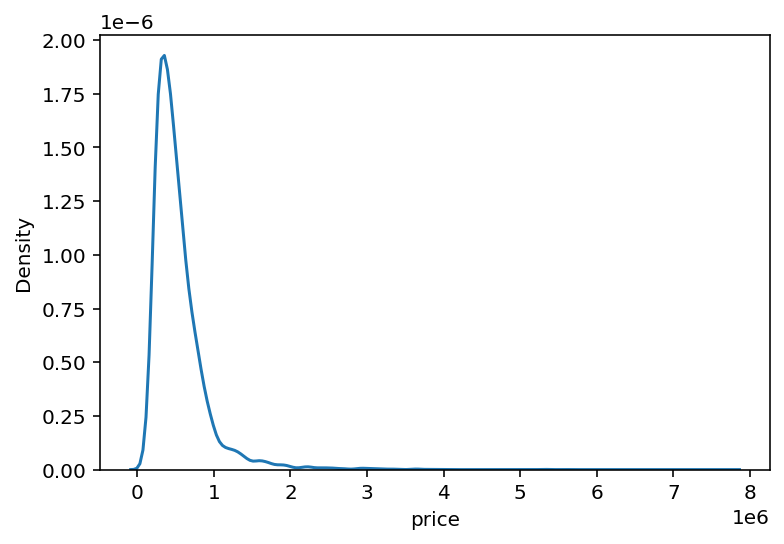

In [8]:
sns.kdeplot(y_train)
plt.show()

In [9]:
y_train = np.log1p(y_train)
y_train

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

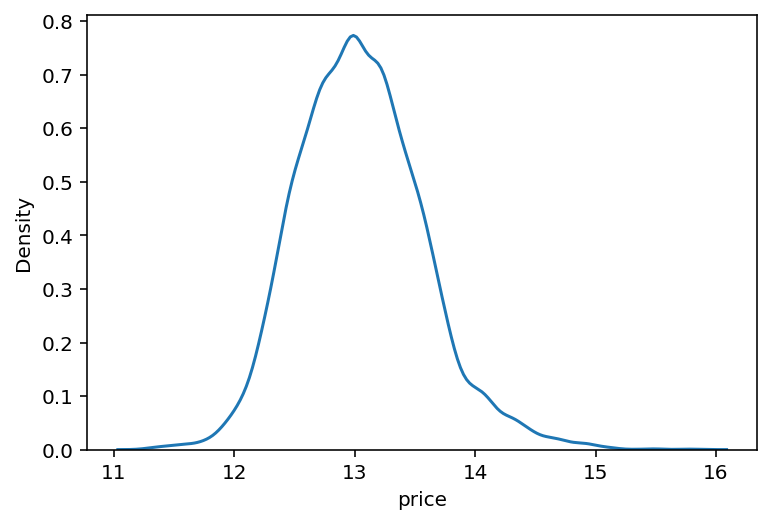

In [10]:
sns.kdeplot(y_train)
plt.show()

### <하이퍼 파라미터 설정>
- n_estimators -> 반복 수행 트리를 늘릴수록 좋지만, 너무 크면 과적합이 발생
- max_depth -> 최대 깊이
- learning_rate -> 학습률
- objective ->회귀(regression)는 LGBM에만 적용.

## Gradient Boosting Regressor

In [11]:
gb_model = GradientBoostingRegressor(max_depth=10, n_estimators=100, learning_rate = 0.05, random_state=2020,max_features = 3)
# gb_model의 n_estimators 를 늘리면 시간이 느려져서 100으로 설정.
gb_model.fit(X_train, y_train)
gb_prediction = gb_model.predict(X_test)
gb_prediction

array([13.20472257, 13.16322156, 14.09033156, ..., 12.97204555,
       12.69611933, 13.00539379])

In [12]:
gb_prediction=np.expm1(gb_prediction)
gb_prediction

array([ 542921.88574559,  520851.18320972, 1316294.03937202, ...,
        430216.23141288,  326477.4861352 ,  444805.12290358])

## LGBM Regressor

In [13]:
lgb_model = lgb.LGBMRegressor(objective = 'regression', max_depth=10, n_estimators=9000, learning_rate = 0.05, random_state=2020)
lgb_model.fit(X_train, y_train)
lgb_prediction = lgb_model.predict(X_test)
lgb_prediction

array([13.06433686, 13.07319171, 14.10745011, ..., 13.10081254,
       12.76069406, 13.05313187])

In [14]:
lgb_prediction = np.expm1(lgb_prediction)
lgb_prediction

array([ 471811.46461015,  476007.84128905, 1339021.07159413, ...,
        489338.8632016 ,  348255.32817679,  466554.31575476])

## XGB Regressor

In [15]:
xgb_model = xgb.XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000, random_state =2020)
xgb_model.fit(X_train, y_train)
xgb_prediction = xgb_model.predict(X_test)
xgb_prediction

array([13.145614 , 12.961858 , 14.241814 , ..., 13.1034155, 12.748208 ,
       13.057249 ], dtype=float32)

In [16]:
xgb_prediction = np.expm1(xgb_prediction)
xgb_prediction

array([ 511760.34,  425855.53, 1531584.  , ...,  490614.25,  343934.03,
        468479.2 ], dtype=float32)

## RandomForest Regressor

In [17]:
rf_model = RandomForestRegressor(max_depth=10, n_estimators=9000, max_features = 3)
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)
rf_prediction

array([13.1841092 , 13.12230345, 14.07826352, ..., 13.0024364 ,
       12.78336208, 13.06233847])

In [18]:
rf_prediction = np.expm1(rf_prediction)
rf_prediction

array([ 531844.97215072,  499969.03504021, 1300504.4010108 , ...,
        443491.60233679,  356239.76256628,  470869.53745864])

# GridSearch CV


In [19]:
# grid의 파라미터를 직접 검색을 하면서 최적을 찾았다. 
lgb_param_grid = {
    'n_estimators': [9000],
    'max_depth': [10],
    'learning_rate' : [0.05],
    'random_state' : [2020]
}

In [20]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model,X_train, y_train):
    grid_model = GridSearchCV(model, param_grid=lgb_param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=1, n_jobs=5)

    grid_model.fit(X_train, y_train)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results=pd.DataFrame(params)
    results['score']=score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by = 'RMSLE')
    return results


In [21]:
from sklearn.model_selection import GridSearchCV

rf_params = { 'n_estimators' : [9000], 'max_depth' : [10], 'max_features' : [3]}

def my_rfSearch(model,X_train, y_train):
    grid_model = GridSearchCV(model, param_grid=rf_params,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=1, n_jobs=5)

    grid_model.fit(X_train, y_train)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results=pd.DataFrame(params)
    results['score']=score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by = 'RMSLE')
    return results

In [22]:
xgb_param_grid = {
    'n_estimators': [900],
    'max_depth': [10],
    'learning_rate' : [0.05],
    'random_state' : [2020]
}
def my_xgbSearch(model,X_train, y_train):
    grid_model = GridSearchCV(model, param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=1, n_jobs=5)

    grid_model.fit(X_train, y_train)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results=pd.DataFrame(params)
    results['score']=score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by = 'RMSLE')
    return results


In [24]:
gb_param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'max_features' : [3],
    'learning_rate' : [0.05],
    'random_state' : [2020]
}
def my_gbGridSearch(model,X_train, y_train):
    grid_model = GridSearchCV(model, param_grid=gb_param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=1, n_jobs=5)

    grid_model.fit(X_train, y_train)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results=pd.DataFrame(params)
    results['score']=score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by = 'RMSLE')
    return results


아래처럼 XGB_model_Grid를 돌렸을때 Kernel Restarting이 되었습니다.

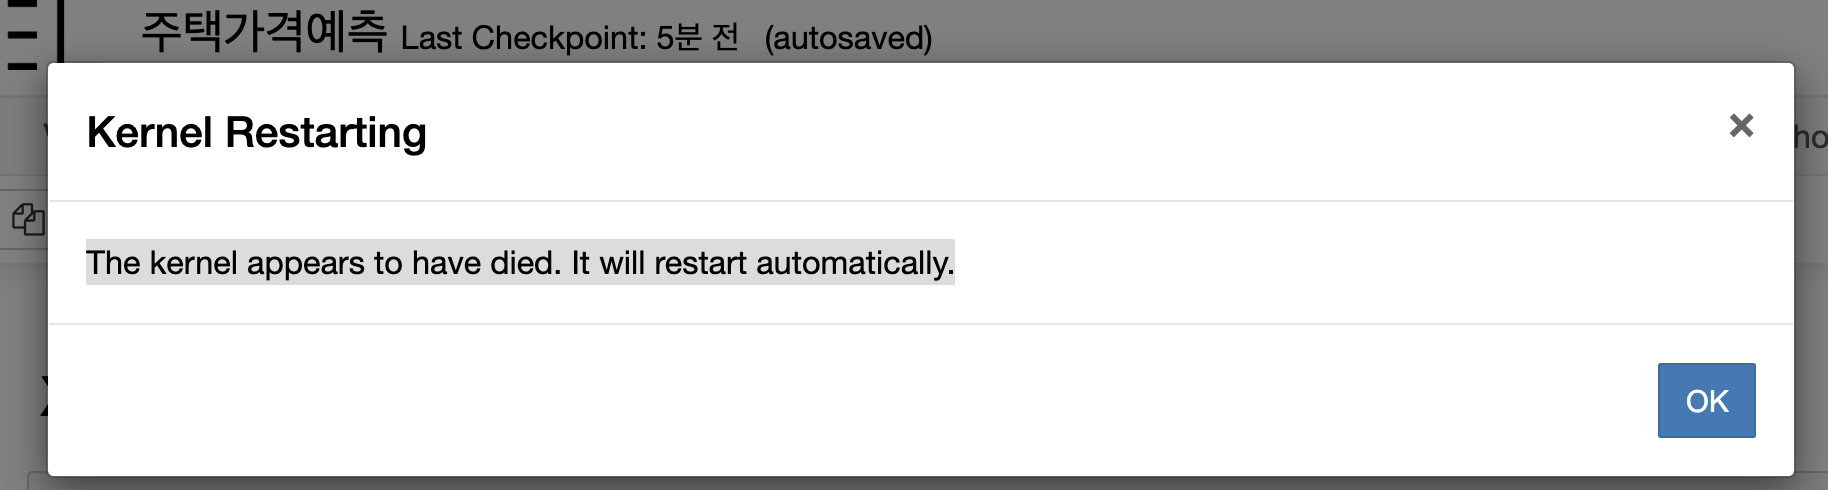

In [25]:
#lgb_model_grid=my_GridSearch(lgb_model,X_train, y_train)
#lgb_model_grid

In [26]:
#gb_model_grid=my_gbGridSearch(gb_model, X_train, y_train)
#gb_model_grid

In [27]:
#xgb_model_grid=my_xgbSearch(xgb_model, X_train, y_train)
#xgb_model_grid

In [28]:
#rf_model_grid=my_rfSearch(rf_model, X_train, y_train)
#rf_model_grid

가중치를 gridsearch에서 rmse를 보고 선정하고 싶었으나, 오래걸리고 에러가 발생하는 점에서  
각각 앙상블의 가중치를 손으로 찾으면서 했습니다.

In [29]:
# Ensemble
prediction = 0.025*gb_prediction+0.8*lgb_prediction + 0.15*xgb_prediction + 0.025*rf_prediction

In [30]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [31]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.810824e+05
1,15036,4.702051e+05
2,15037,1.366374e+06
3,15038,2.832829e+05
4,15039,3.191863e+05


In [32]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'Ensemble', '0.2022')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Ensemble_RMSLE_0.2022.csv


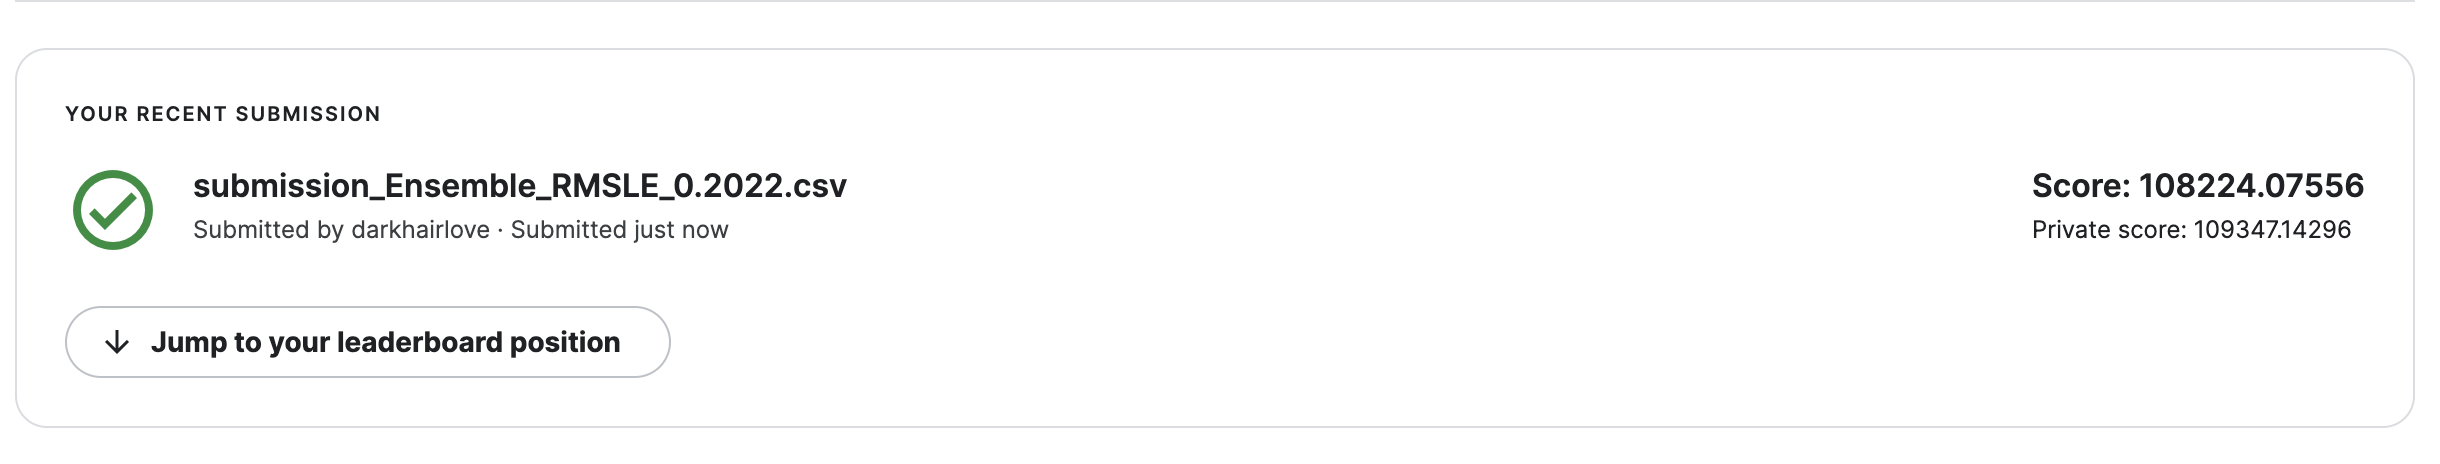

# 회고

1. 어려웠던점 : grid의 param를 찾을 때 속도가 느려서 힘들었고, 앙상블을 사용하는 방법에 대해 찾아보는 점이 오래 걸렸고 어려웠다.
2. 모호한점, 알아낸점 : 블렝딩 방법과 그리드 탐색에 대한 점을 잘 알지 못한것같다.
3. 시도한것 : 주택 가격 예측을 한 여러 가지 예시를 찾아보면서 튜닝 방법을 찾았다.
4. 자기 다짐 : 이론적인 부분을 더 자세히 공부해서 코드로 만드는게 중요하다고 느꼈다.